# First, a little data exploration for what separates classes for each position (utilizing PCA)

In [1]:
# import data, modules
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, classification_report, roc_auc_score, precision_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import mlens
from sklearn.cross_validation import train_test_split
import seaborn as sns
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

[MLENS] backend: threading
C:\Users\Abhijit\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#### we're only going to use the last entry of each player for this case in training
data = pd.read_csv("MergeDataPercentile.csv")
data.dropna(axis=0,inplace= True,subset = ['Per GameGP'])
data = data[data['Pos'] != '0']

hold_out = data[data['Highest Level Reached_x'] == '2017-18']
hold_out['NCAA Seasons\r\r\n(D-I)'] = hold_out.groupby('RealGM Summary Page')['NCAA Seasons\r\r\n(D-I)'].cumcount() + 1
keep_data = data[data['Highest Level Reached_x'] != '2017-18']
keep_data = keep_data.drop_duplicates(subset =  ['RealGM Summary Page'], keep = 'last' )
keep_data['Highest Level Reached_x'] = keep_data['Highest Level Reached_x'].apply(lambda x: 'International' if x != 'NBA' else 'NBA')

C:\Users\Abhijit\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [3]:

feature_set_1 = [ 'Per GameMIN','Misc StatsOWS', 'Misc StatsDWS','Advanced StatsTS%', 'Advanced StatseFG%',
       'Advanced StatsORB%', 'Advanced StatsDRB%', 'Advanced StatsTRB%',
       'Advanced StatsAST%', 'Advanced StatsTOV%', 'Advanced StatsSTL%',
       'Advanced StatsBLK%', 'Advanced StatsUSG%','Advanced StatsPPR', 'Advanced StatsPPS',
       'Advanced StatsORtg', 'Advanced StatsDRtg', 'Advanced StatsPER','Wingspan','Height','Pos','Per Game3P%']
feature_set_2 = ['Per GameMIN','Misc StatsOWS','Misc StatsDWS','Pos','Per GameFG%', 'Per Game3PM',
        'Per Game3P%', 'Per GameFTM',
       'Per GameFT%', 'Per GameDEF', 'Per GameTRB',
       'Per GameAST', 'Per GameSTL', 'Per GameBLK',
       'Per GameTOV', 'Per GamePTS']
feature_set_3 = list(set(feature_set_1).union(set(feature_set_2)))
y_col = ["Highest Level Reached_x"]

le = LabelEncoder()
keep_data['Highest Level Reached_x'] = le.fit_transform(keep_data['Highest Level Reached_x'])

In [4]:
### separate out the data using position as a factor
position_data_dict = {}
positions = np.unique(keep_data['Pos'])
for position in positions:
    position_data_dict[position] = {'features':keep_data[keep_data['Pos'] == position][feature_set_1].select_dtypes(np.number),'target':keep_data[keep_data['Pos'] == position][y_col]}

In [5]:
### pca step here 

### Center

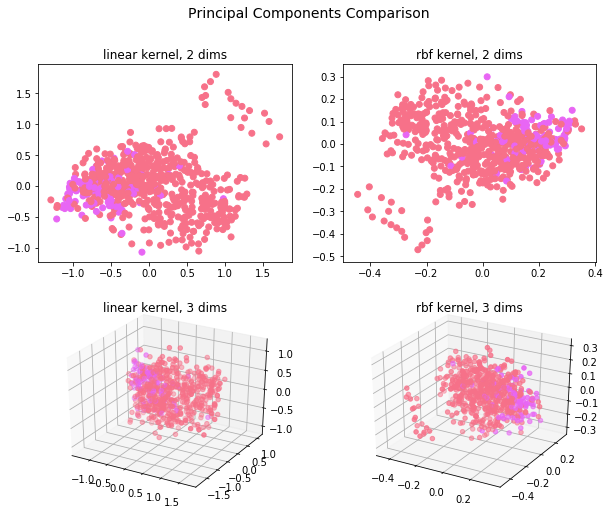

In [6]:
from mlens.visualization.var_analysis import pca_comp_plot
center = positions[0]
center_features = position_data_dict[center]['features']
center_y = position_data_dict[center]['target']
pca_comp_plot(center_features,center_y.values.reshape(len(center_y,)))

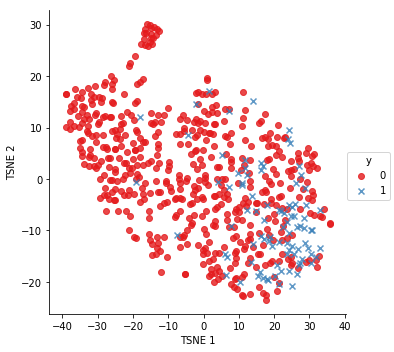

In [7]:
X_use = center_features.select_dtypes(np.number)
X_pca_big = PCA(n_components = 12).fit(X_use).transform(X_use)
X_tsne = TSNE(n_components = 2).fit_transform(X_pca_big)
X_tsne_df = pd.DataFrame(X_tsne,columns = ['TSNE 1','TSNE 2'])
X_tsne_df['y'] = center_y.values
sns.lmplot(x = 'TSNE 1', y = 'TSNE 2',data = X_tsne_df,hue = 'y',fit_reg = False,markers = ['o','x'],palette = 'Set1')
#sns.lmplot(x = 'TSNE 1', y = 'TSNE 2',data = X_tsne_df,hue = 'Pos',fit_reg = False,palette = 'Set1')

We can see that it is easy to classify one cluster of centers, but in the other cluster, this is not so easy. It seems to be that we can use KNN in this condensed space to classify.

### Center-Forward

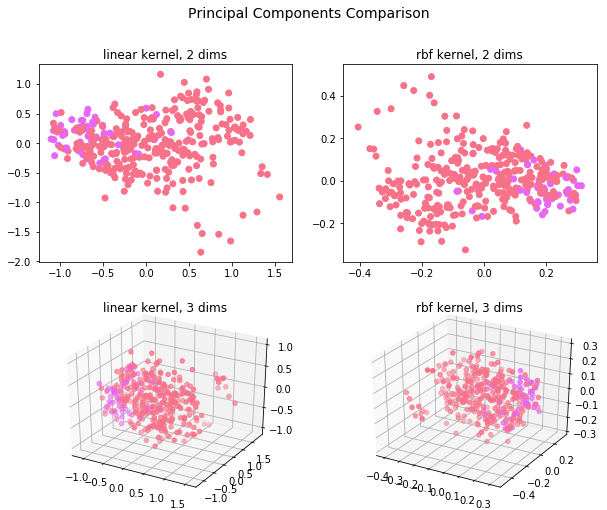

In [8]:
from mlens.visualization.var_analysis import pca_comp_plot
center_forward = positions[1]
center_forward_features = position_data_dict[center_forward]['features']
center_forward_y = position_data_dict[center_forward]['target']
pca_comp_plot(center_forward_features,center_forward_y.values.reshape(len(center_forward_y,)))

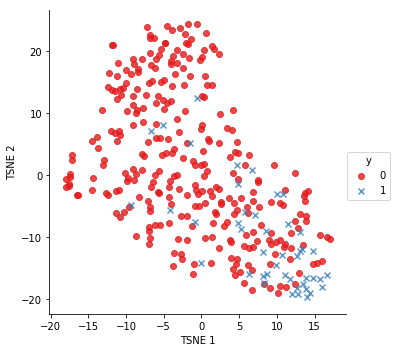

In [9]:
X_use = center_forward_features.select_dtypes(np.number)
X_pca_big = PCA(n_components = 12).fit(X_use).transform(X_use)
X_tsne = TSNE(n_components = 2).fit_transform(X_pca_big)
X_tsne_df = pd.DataFrame(X_tsne,columns = ['TSNE 1','TSNE 2'])
X_tsne_df['y'] = center_forward_y.values
sns.lmplot(x = 'TSNE 1', y = 'TSNE 2',data = X_tsne_df,hue = 'y',fit_reg = False,markers = ['o','x'],palette = 'Set1')

### Forward

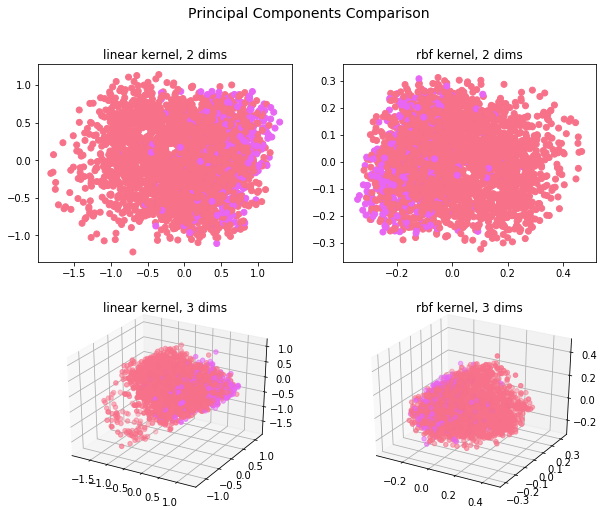

In [10]:
from mlens.visualization.var_analysis import pca_comp_plot
forward = positions[2]
forward_features = position_data_dict[forward]['features']
forward_y = position_data_dict[forward]['target']
pca_comp_plot(forward_features,forward_y.values.reshape(len(forward_y,)))

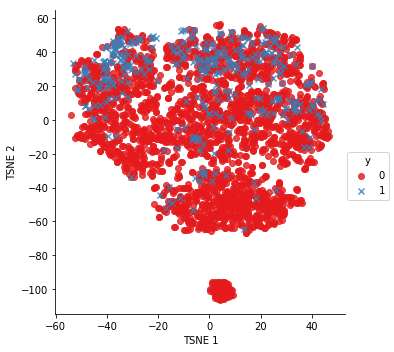

In [11]:
X_use = forward_features.select_dtypes(np.number)
X_pca_big = PCA(n_components = 12).fit(X_use).transform(X_use)
X_tsne = TSNE(n_components = 2).fit_transform(X_pca_big)
X_tsne_df = pd.DataFrame(X_tsne,columns = ['TSNE 1','TSNE 2'])
X_tsne_df['y'] = forward_y.values
sns.lmplot(x = 'TSNE 1', y = 'TSNE 2',data = X_tsne_df,hue = 'y',fit_reg = False,markers = ['o','x'],palette = 'Set1')

Once again, we can see that there is a clean distinction between one set of players the rest of the pack. These are probably far below average players as we see that this also reminds us of what the center plot looks like. KNN here would work best. 

### Foward-Guard

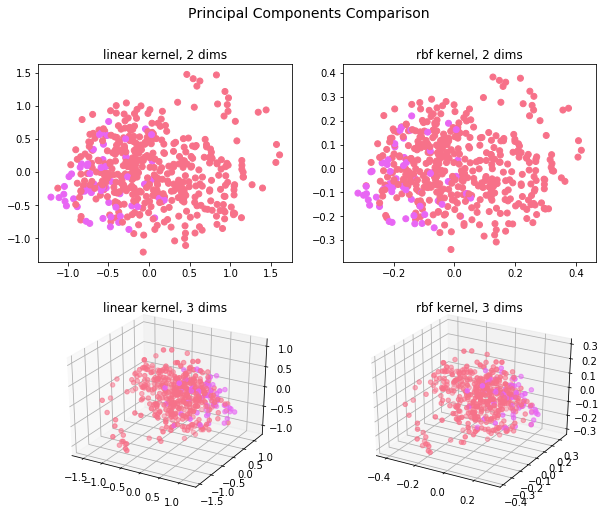

In [12]:
from mlens.visualization.var_analysis import pca_comp_plot
fg = positions[3]
fg_features = position_data_dict[fg]['features']
fg_y = position_data_dict[fg]['target']
pca_comp_plot(fg_features,fg_y.values.reshape(len(fg_y,)))

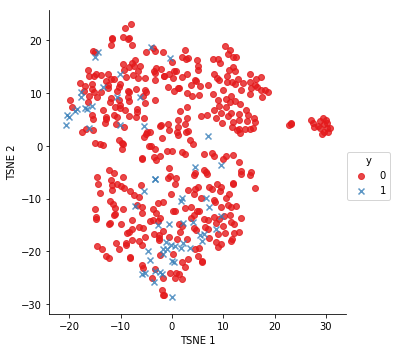

In [13]:
X_use = fg_features.select_dtypes(np.number)
X_pca_big = PCA(n_components = 12).fit(X_use).transform(X_use)
X_tsne = TSNE(n_components = 2).fit_transform(X_pca_big)
X_tsne_df = pd.DataFrame(X_tsne,columns = ['TSNE 1','TSNE 2'])
X_tsne_df['y'] = fg_y.values
sns.lmplot(x = 'TSNE 1', y = 'TSNE 2',data = X_tsne_df,hue = 'y',fit_reg = False,markers = ['o','x'],palette = 'Set1')

### Guard

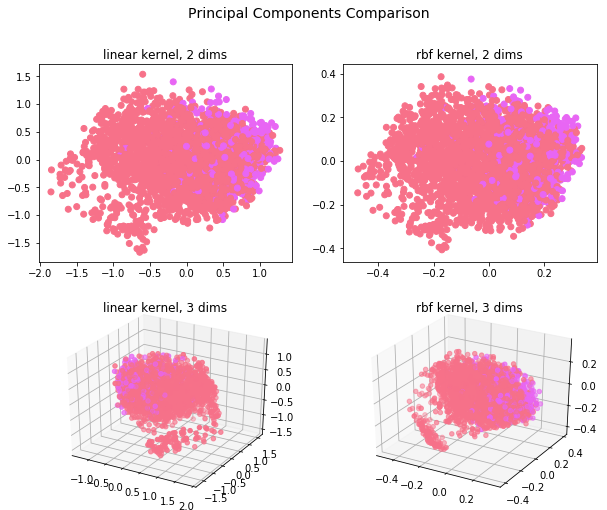

In [14]:
from mlens.visualization.var_analysis import pca_comp_plot
g = positions[-1]
g_features = position_data_dict[g]['features']
g_y = position_data_dict[g]['target']
pca_comp_plot(g_features,g_y.values.reshape(len(g_y,)))

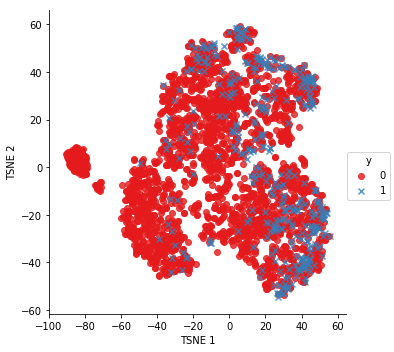

In [15]:
X_use = g_features.select_dtypes(np.number)
X_pca_big = PCA(n_components = 12).fit(X_use).transform(X_use)
X_tsne = TSNE(n_components = 2).fit_transform(X_pca_big)
X_tsne_df = pd.DataFrame(X_tsne,columns = ['TSNE 1','TSNE 2'])
X_tsne_df['y'] = g_y.values
sns.lmplot(x = 'TSNE 1', y = 'TSNE 2',data = X_tsne_df,hue = 'y',fit_reg = False,markers = ['o','x'],palette = 'Set1')

Here it looks like the PCA doesn't really do much to separate out the classes. 
We can try and look for variables that separate well between positions

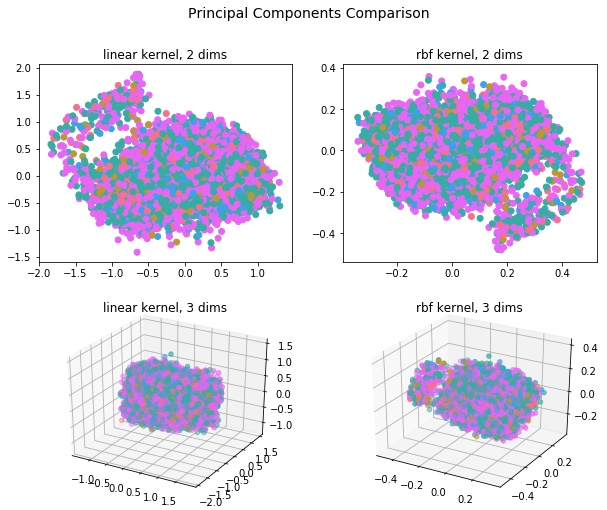

In [16]:
X_use = keep_data[feature_set_1].select_dtypes(np.number)
y_use = LabelEncoder().fit_transform(keep_data['Pos'].values.reshape(len(keep_data,)))
pca_comp_plot(X_use, y_use)

We can't really separate the positions out here using PCA. We don't really intend to separate out the positions, but the class of NBA/Intl. so this exploration isn't necessary.

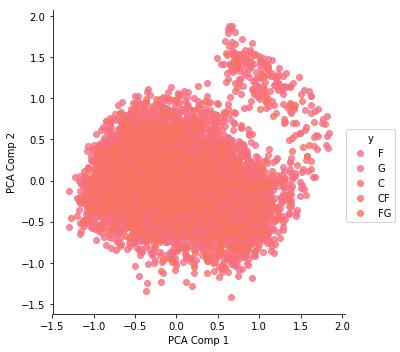

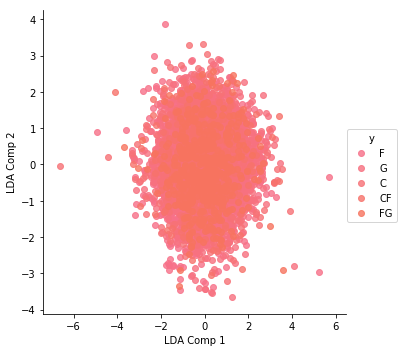

In [17]:
# get the first 2 components of the data, LDA, QDA
X_pca = PCA(n_components = 2).fit(X_use).transform(X_use)
X_lda = LinearDiscriminantAnalysis(n_components = 2).fit(X_use,y_use).transform(X_use)
#X_qda = QuadraticDiscriminantAnalysis(n_components = 2).fit(X_use,y_use).transform(X_use)
### make dataframe  
X_pca_df = pd.DataFrame(X_pca,columns = ['PCA Comp 1','PCA Comp 2'])
X_pca_df['y'] = keep_data['Pos'].values
X_lda_df = pd.DataFrame(X_lda,columns = ['LDA Comp 1','LDA Comp 2'])
X_lda_df['y'] = keep_data['Pos'].values
#X_qda_df = pd.DataFrame(X_qda,columns = ['QDA Comp 1','QDA Comp 2'])
#X_qda_df = keep_data['Pos'].values

### plot these things separately
sns.lmplot(x = 'PCA Comp 1', y = 'PCA Comp 2',data = X_pca_df,hue = 'y',fit_reg = False)
sns.lmplot(x = 'LDA Comp 1', y = 'LDA Comp 2',data = X_lda_df,hue = 'y',fit_reg = False)
#sns.lmplot(x = 'QDA Comp 1', y = 'QDA Comp 2',data = X_qda_df,hue = 'y',fit_reg = False)

Looks like we can't separate out the positions based on the information given. Now, let's try and separate out the NBA/Intl. label.

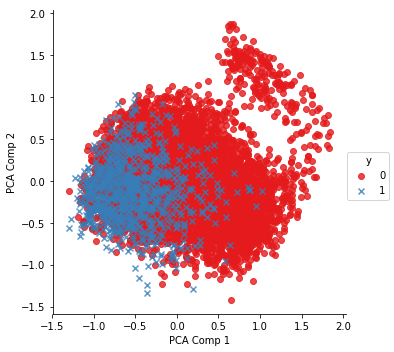

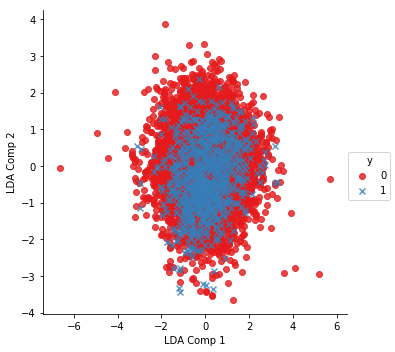

In [18]:
X_pca_df['y'] = keep_data['Highest Level Reached_x'].values
X_lda_df['y'] = keep_data['Highest Level Reached_x'].values
sns.lmplot(x = 'PCA Comp 1', y = 'PCA Comp 2',data = X_pca_df,hue = 'y',fit_reg = False,markers = ['o','x'],palette = 'Set1')
sns.lmplot(x = 'LDA Comp 1', y = 'LDA Comp 2',data = X_lda_df,hue = 'y',fit_reg = False,markers = ['o','x'],palette = 'Set1')

Let's now see if we can just separate based on the first 5 PCA components transformed into t-sne space.

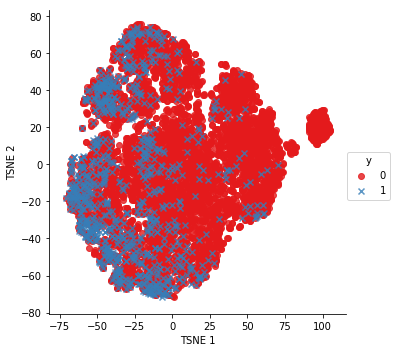

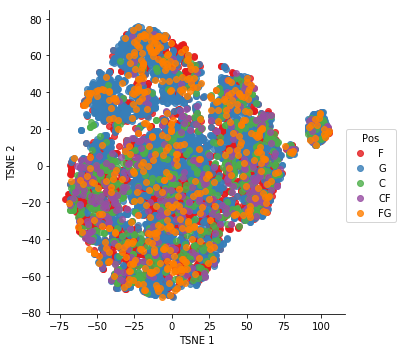

In [19]:
X_pca_big = PCA(n_components = 12).fit(X_use).transform(X_use)
X_tsne = TSNE(n_components = 2).fit_transform(X_pca_big)
X_tsne_df = pd.DataFrame(X_tsne,columns = ['TSNE 1','TSNE 2'])
X_tsne_df['y'] = keep_data['Highest Level Reached_x'].values
X_tsne_df['Pos'] = keep_data['Pos'].values
sns.lmplot(x = 'TSNE 1', y = 'TSNE 2',data = X_tsne_df,hue = 'y',fit_reg = False,markers = ['o','x'],palette = 'Set1')
sns.lmplot(x = 'TSNE 1', y = 'TSNE 2',data = X_tsne_df,hue = 'Pos',fit_reg = False,palette = 'Set1')

In [20]:
#### let's do a little model selection for KNN classifier on 2 PCA Components
knn_range = np.arange(1,100,3)
weight_method = ['distance','uniform']
knn_model_dict = {}
n_components = 2
kernel_method = ['rbf','linear','poly','cosine']
for position in positions:
    best_classifier = None
    best_score = 0
    best_pca = None
    position_data = position_data_dict[position]['features']
    position_y = position_data_dict[position]['target']
    X_train,X_val,y_train,y_val = train_test_split(position_data,position_y,test_size= .2,random_state = 42)
    for kernel in kernel_method:
        pca = KernelPCA(n_components = n_components,kernel = kernel)
        X_pca_train = pca.fit_transform(X_train)
        X_pca_val = pca.transform(X_val)
        for k in knn_range:
            for weight in weight_method:
                knn_model = KNeighborsClassifier(n_neighbors = k,weights = weight)
                knn_model.fit(X_pca_train,y_train)
                pred_y_val = knn_model.predict(X_pca_val)
                score = f1_score(y_val,pred_y_val)
                if score > best_score:
                    best_classifier = knn_model
                    best_pca = pca
                    best_score = score
    knn_model_dict[position] = (best_classifier,best_pca,best_score)

                

C:\Users\Abhijit\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Abhijit\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
### let's do a little model selection for the logistic regression 
position_model_dict = {}
c_vals = [.1,.5,1,10,50,100]
penalties = ['l1','l2']
for position in positions:
    position_data = position_data_dict[position]['features']
    position_y = position_data_dict[position]['target']
    X_train,X_val,y_train,y_val = train_test_split(position_data,position_y,test_size= .2,random_state = 42)
    best_pos_score = 0
    best_pos_classifier = None
    for c in c_vals:
        for penalty in penalties:
            pos_classifier = LogisticRegression(C = c,penalty = penalty,class_weight = 'balanced')
            pos_classifier.fit(X_train,y_train)
            y_pred = pos_classifier.predict(X_val)
            score = f1_score(y_pred,y_val)
            
            if score > best_pos_score:
                best_pos_classifier = pos_classifier
                best_pos_score = score
    y_pred = best_pos_classifier.predict(X_val)
    f1 = f1_score(y_pred,y_val)
    position_model_dict[position] = (best_pos_classifier,f1)
            

C:\Users\Abhijit\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
position_model_dict

{'C': (LogisticRegression(C=10, class_weight='balanced', dual=False,
            fit_intercept=True, intercept_scaling=1, max_iter=100,
            multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
            solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
  0.62745098039215685),
 'CF': (LogisticRegression(C=1, class_weight='balanced', dual=False,
            fit_intercept=True, intercept_scaling=1, max_iter=100,
            multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
            solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
  0.57142857142857151),
 'F': (LogisticRegression(C=1, class_weight='balanced', dual=False,
            fit_intercept=True, intercept_scaling=1, max_iter=100,
            multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
            solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
  0.51181102362204722),
 'FG': (LogisticRegression(C=10, class_weight='balanced', dual=False,
       

In [23]:
hold_out_predictions = {}
for position_key in position_model_dict:
    pos_model = position_model_dict[position_key][0]
    hold_out_pos = hold_out[hold_out['Pos'] == position_key]
    hold_out_prediction_probabilities = pos_model.predict_proba(hold_out_pos[feature_set_1].select_dtypes(np.number))
    hold_out_prediction = pos_model.predict(hold_out_pos[feature_set_1].select_dtypes(np.number))
    df = pd.DataFrame(hold_out_prediction_probabilities,columns=['Intl. Prob','NBA Prob.'])
    df['Predictions'] = hold_out_prediction
    df['Name'] = hold_out_pos['Name'].values
    df['Year'] = hold_out_pos['Year'].values
    hold_out_predictions[position_key] = df
    
    

In [24]:
hold_out_predictions['G'][hold_out_predictions['G']['Predictions'] == 1].sort_values('NBA Prob.',ascending=False)
# hold_out_predictions['F'].shape

,Intl. Prob,NBA Prob.,Predictions,Name,Year
414,0.069991,0.930009,1,Shake Milton,2017.0
365,0.084134,0.915866,1,Jacob Evans,2017.0
158,0.093760,0.906240,1,"Bonzie Colson, Jr.",2017.0
147,0.100116,0.899884,1,Jevon Carter,2018.0
128,0.123017,0.876983,1,Jacobi Boykins,2017.0
169,0.124212,0.875788,1,Keenan Evans,2018.0
500,0.126146,0.873854,1,Tony Carr,2018.0
93,0.141669,0.858331,1,Muhammad-Ali Abdur-Rahkman,2018.0
165,0.148404,0.851596,1,Jon Elmore,2018.0
31,0.155279,0.844721,1,Devon Hall,2018.0


In [25]:
hold_out_predictions_knn = {}
for position_key in knn_model_dict:
    pos_model = knn_model_dict[position_key][0]
    pca = knn_model_dict[position_key][1]
    hold_out_pos = hold_out[hold_out['Pos'] == position_key]
    hold_out_pca = pca.transform(hold_out_pos[feature_set_1].select_dtypes(np.number))
    hold_out_prediction_probabilities = pos_model.predict_proba(hold_out_pca)
    hold_out_prediction = pos_model.predict(hold_out_pca)
    df = pd.DataFrame(hold_out_prediction_probabilities,columns=['Intl. Prob','NBA Prob.'])
    df['Predictions'] = hold_out_prediction
    df['Name'] = hold_out_pos['Name'].values
    df['Year'] = hold_out_pos['Year'].values
    hold_out_predictions_knn[position_key] = df

In [26]:
hold_out_predictions_knn['C'][hold_out_predictions_knn['C']['Predictions'] == 1].sort_values('NBA Prob.',ascending=False)
# hold_out_predictions['F'].shape

,Intl. Prob,NBA Prob.,Predictions,Name,Year
2,0.174575,0.825425,1,Paschal Chukwu,2018.0
96,0.220693,0.779307,1,Brandon McCoy,2018.0
5,0.237726,0.762274,1,Nana Foulland,2017.0
17,0.269087,0.730913,1,Jock Landale,2017.0
73,0.315296,0.684704,1,Doral Moore,2018.0
31,0.370358,0.629642,1,Dylan Osetkowski,2018.0
51,0.407895,0.592105,1,Robert Franks,2016.0
99,0.439782,0.560218,1,Jericho Sims,2018.0
84,0.490733,0.509267,1,Udoka Azubuike,2018.0


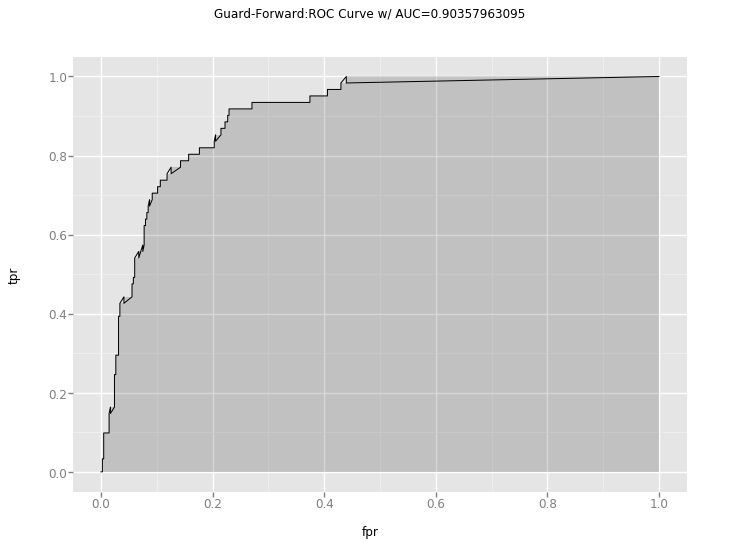

<ggplot: (132613240703)>

In [37]:
from ggplot import * 
from sklearn.metrics import auc, roc_curve
classifier = position_model_dict['FG'][0]

pos_data,pos_target = position_data_dict['FG']['features'],position_data_dict['FG']['target']
prediction = classifier.predict_proba(pos_data)[:,1]
fpr,tpr,_ = roc_curve(pos_target,prediction)
auc_score = auc(fpr,tpr)
#conf_mat = pd.DataFrame(confusion_matrix(prediction,y_val),columns = ['Predicted Intl.','Predicted NBA'],index = ['Actual Intl.','Actual NBA'])
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', ymin='0', y='tpr')) +\
 geom_area(alpha=0.2) +\
 geom_line(aes(y='tpr')) +\
 ggtitle('Guard-Forward:' + "ROC Curve w/ AUC=%s" % str(auc_score))
#print(conf_mat)


In [ ]:
big_df = pd.DataFrame()
for position in positions:
    coef_df = pd.DataFrame()
    model = position_model_dict[position][0]
    coefficients = model.coef_[0]
    #print(coefficients)
    pos_label = [position] * len(coefficients)
    features = position_data_dict[position]['features'].columns.values
    coef_df['Coefficients'] = coefficients
    coef_df['Position'] = pos_label
    coef_df['Features'] = features
    big_df = pd.concat([big_df,coef_df])
big_df.to_csv("regression_coefficients.csv",index=False)


In [ ]:
print(fpr)
print(tpr)